# Implementing the Ahnert and Payne scheme for a general 1-qubit  POVM on qiskit.



In [20]:
from numpy import pi
import numpy as np

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram
import math


/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)
WARNING Unable to compile latex. The output from the pdflatex command can be found in latex_error.log


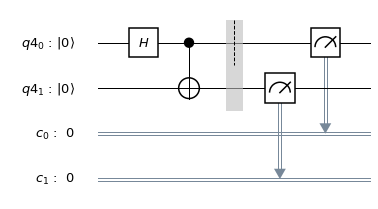

In [22]:
q = QuantumRegister(2)

qc = QuantumCircuit(q)

qc.h(q[0])
qc.cx(q[0],q[1])
# qc.initialize(desired_vector, [q[0],q[1],q[2]])
# Add Measurements

# Create a Classical Register with 3 bits.
c = ClassicalRegister(2, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)
meas.barrier(q)
# map the quantum measurement to the classical bits
meas.measure(q,c)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc+meas

circuit_drawer(qc)


In [23]:
from qiskit import BasicAer

backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
qc_state = job.result().get_statevector(qc)
qc_state 

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

### Run the simulator

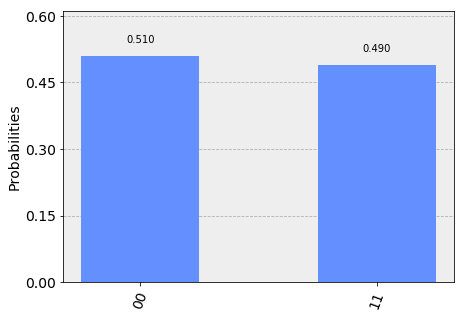

In [24]:
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
shots = 8096

# Create a Quantum Program for execution 
job = execute(qc, backend, shots = shots)

# execute
result = job.result()

counts = result.get_counts(qc)
plot_histogram(counts)

### REAL DEVICE EXPERIMENT


In [25]:

# IBMQ.save_account(token)
IBMQ.load_accounts()


shots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 10       # Maximum number of credits to spend on executions. 
n_qubits = 3


large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits > n_qubits and
                                                       not x.configuration().simulator)
backend = least_busy(large_enough_devices)
# backend = IBMQ.backends(filters=lambda x: x.name == 'ibmqx5')
print("The best backend is " + backend.name())

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/providers/ibmq/credentials/_configrc.py:129: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. Set overwrite=True to overwrite.')
/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


The best backend is ibmq_16_melbourne


In [37]:
# <<<<<<<<<<< EXECUTING real experiment >>>>>>>>>>>>>>
run = 1  # keep 0 untill you want to run the experiment, to avoid running by mistake. It is slow and cost credits!
if run:
    job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    result = job_exp.result()

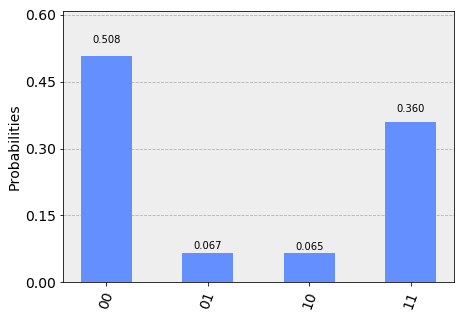

In [38]:
counts = result.get_counts(qc)
plot_histogram(counts)

In [39]:
from qiskit.quantum_info import state_fidelity

def state_vector(counts):

    terms = list(counts.keys())
    terms.sort()
    last = terms[-1]
    n = len(last)

    vector = np.zeros(2**n)
    vector_module = 0

    for i in range(2**n):
        vector[i] = counts[terms[i]]
        vector_module += vector[i]*vector[i]

    return vector / np.sqrt(vector_module)


desired_vector = [1/np.sqrt(2),0,0,1/np.sqrt(2)]
qc_state = state_vector(counts)
state_fidelity(desired_vector,qc_state)
# qc_state

0.9505531467609701